<a href="https://colab.research.google.com/github/ADIthaker/Credit-Card-Fraud-Detection/blob/master/Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset and dependencies

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d pablotab/mnistpklgz

 53% 17.0M/32.1M [00:00<00:00, 40.1MB/s]
100% 32.1M/32.1M [00:00<00:00, 63.9MB/s]


In [2]:
! unzip -q mnistpklgz.zip

In [ ]:
! git clone --recursive https://github.com/dmlc/xgboost
! make -j4 --directory=xgboost
! python ./xgboost/python-package/setup.py install

! pip install conda
! conda install libgcc
import xgboost as xgb

# Import Dependencies and Utils

In [4]:
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip
'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [5]:
curr_path = os.getcwd()
file = '/mnist.pkl.gz'
f = gzip.open(curr_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()
X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [6]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [8]:
train_index = range(0, len(X_train))
validation_index = range(len(X_train), len(X_train)+ len(X_validation))
test_index = range(len(X_train)+ len(X_validation), len(X_train)+ len(X_validation)+len(X_test))


X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.DataFrame(data=y_train, index=train_index)

X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.DataFrame(data=y_validation, index=validation_index)

X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.DataFrame(data=y_test, index=test_index)

In [9]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000010,0.000037,0.000017,7.031250e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.000004,0.000044,0.000108,0.000155,0.000210,0.000380,0.000570,...,0.013975,0.010081,0.006603,0.003967,0.002168,0.001039,0.000333,0.000067,2.343750e-07,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.000012,0.000067,0.000173,0.000377,0.000501,0.000709,0.001159,0.001440,0.001910,0.002044,0.002479,0.002171,0.001725,0.001215,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002034,0.005825,0.003773,1.572223e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000280,0.000833,0.004514,0.008921,0.010814,0.012095,0.016715,0.020658,...,0.102319,0.086386,0.070681,0.054545,0.041041,0.027224,0.014586,0.005078,5.240772e-05,0.001031,0.0,0.0,0.0,0.0,0.0,0.0,0.001872,0.007228,0.010340,0.016519,0.019057,0.023204,0.027897,0.032083,0.037493,0.037788,0.042872,0.039894,0.034695,0.029488,0.022778,0.015422,0.012079,0.007217,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [10]:
y_train.head()

,0
0,5
1,0
2,4
3,1
4,9


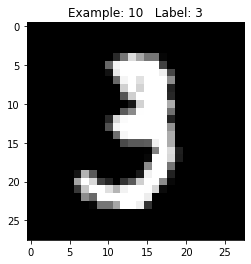

In [18]:
def view_digit(example):
  label = y_train.loc[example]
  image = X_train.loc[example,:].values.reshape([28,28])
  plt.title('Example: %d   Label: %d' % (example, label))
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.show()
view_digit(10)

In [67]:
def scatterPlot(xDF, yDF, algoName):
  tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
  tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
  tempDF.columns = ["First Vector", "Second Vector", "Label"]
  sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
  ax = plt.gca()
  ax.set_title("Separation of Observations using "+algoName)

# Dimension Reduction Models

## Linear Projection

### PCA

In [20]:
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)
print("Variance Explained by all 784 principal components: ", sum(pca.explained_variance_ratio_))

Variance Explained by all 784 principal components:  1.0000000252108534


In [21]:
X_train_PCA

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0.461506,-1.246868,0.046378,-2.151917,-0.247400,-0.925444,0.889332,0.507082,-1.541715,0.689383,0.725362,-1.102925,-0.219290,2.902719,-0.938847,0.137723,1.356489,1.290729,0.935386,0.522249,0.138181,-0.272575,-0.692824,1.053894,0.201189,0.308477,-1.224719,0.740826,0.402566,-0.494797,-0.355023,0.251738,0.475713,0.327049,-0.570176,-0.821341,0.087746,0.804360,0.735308,-1.285615,...,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.777686e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,3.921672,-1.251671,2.335506,-1.340481,-3.421546,-0.725555,-0.206375,-0.345281,0.134142,0.595471,-1.139371,-0.363437,-1.310815,0.502294,0.753733,-0.723343,-0.202876,0.152335,0.189695,-0.434814,0.832807,-0.365208,-0.058027,0.023807,0.880844,0.820460,-0.007329,0.205831,1.383569,-0.377493,-0.008192,-0.387913,0.759156,0.169556,-0.548218,-0.377969,-0.239639,-0.142035,0.299834,0.159002,...,1.186093e-06,-8.416374e-07,-3.006472e-07,9.883292e-07,3.365307e-07,3.076824e-07,-1.799337e-07,1.464489e-08,1.960051e-07,-8.437256e-08,-1.592736e-07,1.353943e-07,-4.553150e-07,-2.658312e-07,-5.792480e-07,-1.526746e-07,-1.363061e-07,6.810993e-08,7.779975e-09,-6.131742e-08,-7.150833e-08,6.888820e-08,7.439808e-08,4.244242e-08,1.700148e-08,-1.120401e-10,-3.674896e-09,3.515149e-10,6.439740e-09,4.397024e-09,3.468968e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.405852e-08,-5.239870e-06,-1.437667e-06,-3.109496e-08,2.424920e-07
2,-0.203707,1.547993,-0.980390,2.039079,-1.079781,0.112964,-3.312378,1.403168,-0.592932,-0.763885,1.740453,-0.667757,0.691351,0.383733,0.521176,-0.779156,0.611273,-0.561018,-0.085419,-1.701513,-0.279228,0.020493,0.468989,-0.006158,-0.484971,0.381903,0.668271,0.475546,-0.069912,-1.154159,-0.041171,0.454417,-0.295350,-0.260015,0.285520,-0.660183,0.772182,-0.704752,0.190407,0.080598,...,-1.304558e-06,2.239336e-06,1.087694e-06,3.449189e-07,1.312204e-07,-7.839861e-07,-1.243094e-06,-6.289258e-08,-3.841198e-07,5.094459e-07,-4.417357e-07,-2.042690e-07,-4.868890e-07,-2.340529e-07,-3.485381e-07,-3.513563e-07,-2.612222e-09,-5.612520e-08,-1.340941e-09,-4.746044e-08,-9.602056e-08,5.704910e-08,4.698616e-08,6.480159e-08,3.307674e-08,8.890164e-10,-2.897034e-09,-6.428406e-09,2.990289e-09,-1.958285e-09,-5.486454e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.514581e-08,-6.113017e-07,-9.611122e-07,-2.350143e-06,2.030429e-07
3,-3.148398,-2.296125,1.091190,0.484562,0.066973,2.778977,-1.834322,-0.174686,1.166468,0.052839,-1.703557,-0.562721,0.924425,0.646384,0.690596,0.114802,0.055195,0.793628,0.481824,0.433194,-0.250298,-0.537311,0.116170,-0.423242,0.488960,0.076868,-1.062277,0.616796,-0.085235,-0.450933,-0.097395,-0.254126,-0.400584,-0.408557,0.508972,-0.304029,-0.000041,-0.037769,-0.165781,0.226486,...,6.570234e-08,-1.268718e-06,4.140768e-07,1.579990e-06,-3.266425e-07,1.483935e-07,-6.122625e-07,1.941847e-07,-6.427972e-07,4.876904e-07,-2.392069e-07,4.602606e-07,-1.298984e-07,-9.199007e-08,-4.298992e-07,1.568451e-07,7.946180e-08,-7.610681e-08,3.038684e-08,-4.437409e-08,-7.042982e-08,5.524630e-08,6.454624e-08,-1.321920e-08,-2.803429e-08,3.119826e-10,-6.741049e-09,7.926031e-09,8.778463e-09,1.309715e-08,9.262759e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.787787e-09,4.904428e-06,1.107317e-06,-4.246802e-07,-4.107102e-07
4,-1.442697,2.872033,0.175532,-0.97

In [68]:
importanceOfPC = pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPC = importanceOfPC.T
def explained_variance(x):
  print('Variance Captured by First %d Principal Components: '%(x),importanceOfPC.loc[:,0:x-1].sum(axis=1).values)
explained_variance(10)
explained_variance(20)
explained_variance(50)
explained_variance(100)
explained_variance(200)
explained_variance(300)

Variance Captured by First 10 Principal Components:  [0.48876244]
Variance Captured by First 20 Principal Components:  [0.6439803]
Variance Captured by First 50 Principal Components:  [0.824861]
Variance Captured by First 100 Principal Components:  [0.91465855]
Variance Captured by First 200 Principal Components:  [0.96650076]
Variance Captured by First 300 Principal Components:  [0.9862489]


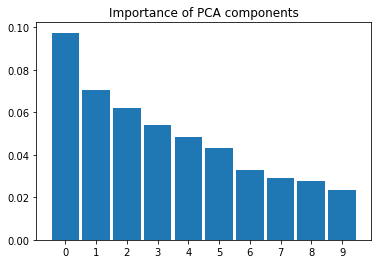

In [69]:
plt.bar(np.arange(10), pca.explained_variance_ratio_[:10],width=-0.9)
ax = plt.gca()
ax.set_xticks(list(range(10)))
plt.title('Importance of PCA components')
plt.show()

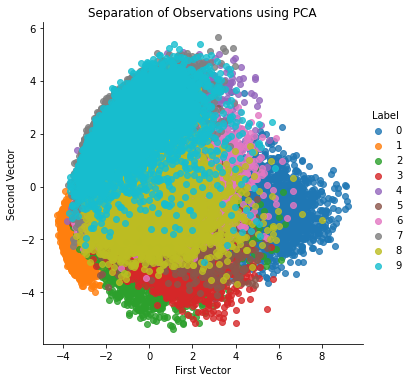

In [70]:
scatterPlot(X_train_PCA, y_train, "PCA")

#### Incremental PCA

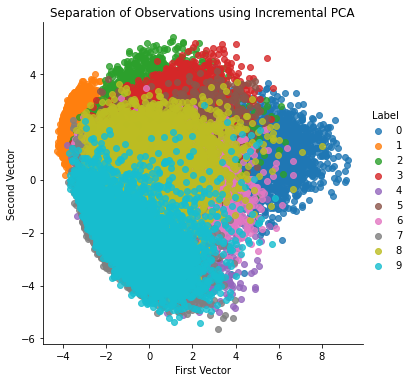

In [71]:
from sklearn.decomposition import IncrementalPCA

incrementalPCA = IncrementalPCA(n_components=784,batch_size=None)

X_train_incrementalPCA = incrementalPCA.fit_transform(X_train)
X_train_incrementalPCA = pd.DataFrame(data=X_train_incrementalPCA, index=train_index)

X_validation_incrementalPCA = incrementalPCA.transform(X_validation)
X_validation_incrementalPCA = pd.DataFrame(data=X_validation_incrementalPCA, index=validation_index)

scatterPlot(X_train_incrementalPCA, y_train, "Incremental PCA")

#### Sparse PCA

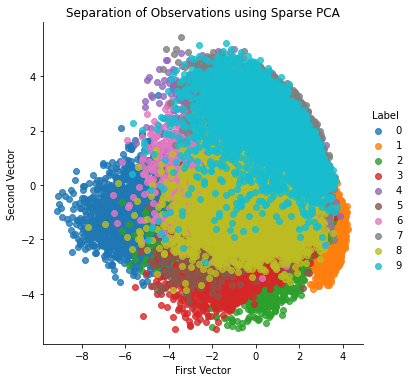

In [72]:
from sklearn.decomposition import SparsePCA

sparsePCA = SparsePCA(n_components=100, alpha=0.0001,random_state=2018, n_jobs=-1)
sparsePCA.fit(X_train.loc[:10000,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=train_index)
X_validation_sparsePCA = sparsePCA.transform(X_validation)
X_validation_sparsePCA = pd.DataFrame(data=X_validation_sparsePCA, index=validation_index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")


#### Kernel PCA

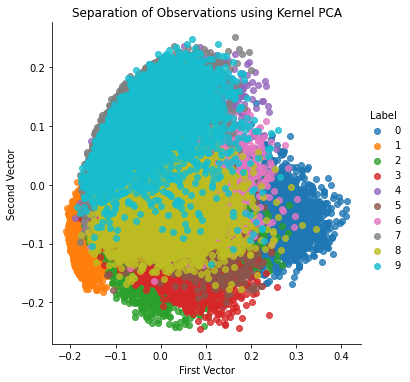

In [73]:
from sklearn.decomposition import KernelPCA

kernelPCA = KernelPCA(n_components=100, kernel='rbf', gamma=None, n_jobs=1, random_state=2018)

kernelPCA.fit(X_train.loc[:10000,:])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA,index=train_index)
X_validation_kernelPCA = kernelPCA.transform(X_validation)
X_validation_kernelPCA = pd.DataFrame(data=X_validation_kernelPCA, index=validation_index)
scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

### SVD

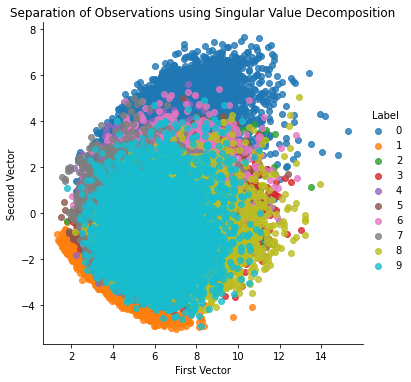

In [74]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200, algorithm='randomized', n_iter=5,random_state=2018)

X_train_svd = svd.fit_transform(X_train)
X_train_svd = pd.DataFrame(data=X_train_svd, index=train_index)
X_validation_svd = svd.transform(X_validation)
X_validation_svd = pd.DataFrame(data=X_validation_svd, index=validation_index)
scatterPlot(X_train_svd, y_train, "Singular Value Decomposition")


### Random Projection

#### Gaussian Random Projection

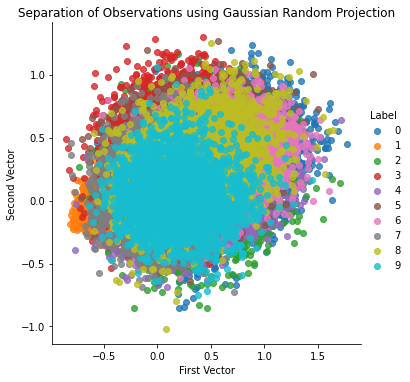

In [75]:
from sklearn.random_projection import GaussianRandomProjection
n_components = 'auto'
eps = 0.5
random_state = 2018
GRP = GaussianRandomProjection(n_components=n_components, eps=eps,random_state=random_state)
X_train_GRP = GRP.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=train_index)
X_validation_GRP = GRP.transform(X_validation)
X_validation_GRP = pd.DataFrame(data=X_validation_GRP, index=validation_index)
scatterPlot(X_train_GRP, y_train, "Gaussian Random Projection")

#### Sparse Random Projection

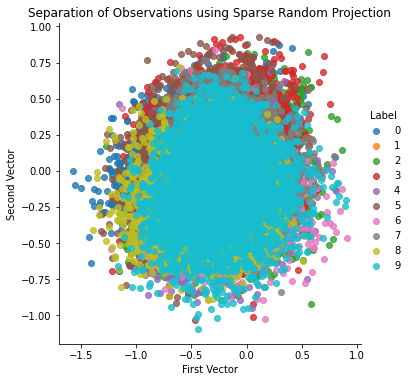

In [76]:
from sklearn.random_projection import SparseRandomProjection
n_components = 'auto'
density = 'auto'
eps = 0.5
dense_output = False
random_state = 2018
SRP = SparseRandomProjection(n_components=n_components, density=density, eps=eps, dense_output=dense_output, random_state=random_state)
X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=train_index)
X_validation_SRP = SRP.transform(X_validation)
X_validation_SRP = pd.DataFrame(data=X_validation_SRP, index=validation_index)
scatterPlot(X_train_SRP, y_train, "Sparse Random Projection")

## Manifold Learning

### Isomap

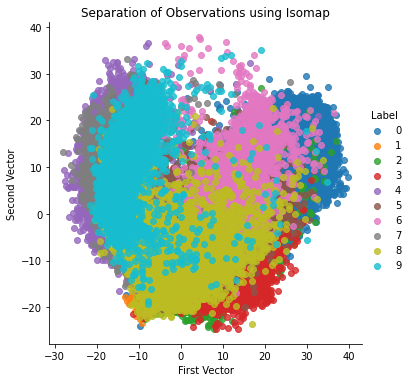

In [77]:
from sklearn.manifold import Isomap
n_neighbors = 5
n_components = 10
n_jobs = 4
isomap = Isomap(n_neighbors=n_neighbors,n_components=n_components, n_jobs=n_jobs)
isomap.fit(X_train.loc[0:5000,:])
X_train_isomap = isomap.transform(X_train)
X_train_isomap = pd.DataFrame(data=X_train_isomap, index=train_index)
X_validation_isomap = isomap.transform(X_validation)
X_validation_isomap = pd.DataFrame(data=X_validation_isomap,index=validation_index)
scatterPlot(X_train_isomap, y_train, "Isomap")

### Multidimensional Scaling

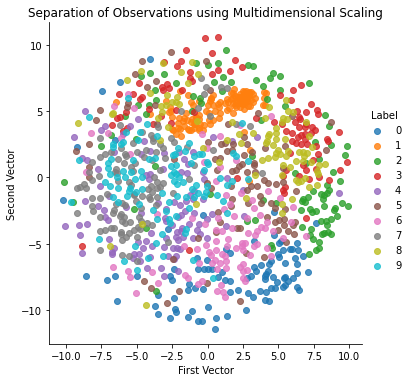

In [78]:
from sklearn.manifold import MDS
n_components = 2
n_init = 12
max_iter = 1200
metric = True
n_jobs = 4
random_state = 2018
mds = MDS(n_components=n_components, n_init=n_init, max_iter=max_iter, \
metric=metric, n_jobs=n_jobs, random_state=random_state)
X_train_mds = mds.fit_transform(X_train.loc[0:1000,:])
X_train_mds = pd.DataFrame(data=X_train_mds, index=train_index[0:1001])
scatterPlot(X_train_mds, y_train, "Multidimensional Scaling")

### Locally Linear Embedding

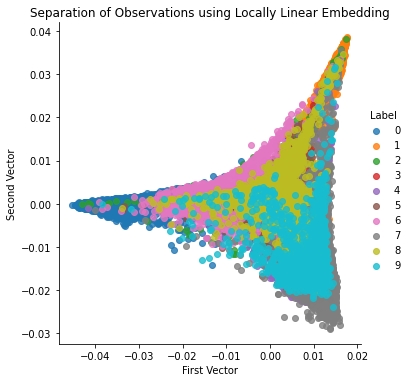

In [79]:
from sklearn.manifold import LocallyLinearEmbedding
n_neighbors = 10
n_components = 2
method = 'modified'
n_jobs = 4
random_state = 2018
lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, \
n_components=n_components, method=method, \
random_state=random_state, n_jobs=n_jobs)
lle.fit(X_train.loc[0:5000,:])
X_train_lle = lle.transform(X_train)
X_train_lle = pd.DataFrame(data=X_train_lle, index=train_index)
X_validation_lle = lle.transform(X_validation)
X_validation_lle = pd.DataFrame(data=X_validation_lle, index=validation_index)
scatterPlot(X_train_lle, y_train, "Locally Linear Embedding")

### t-Distributed Stochastic Neighbor Embedding

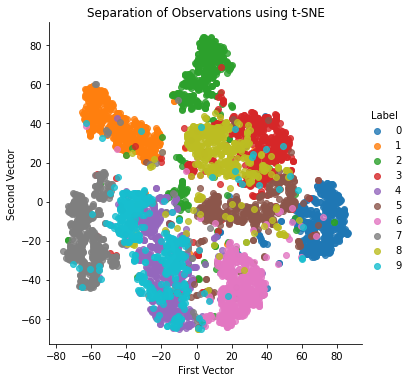

In [80]:
from sklearn.manifold import TSNE
n_components = 2
learning_rate = 300
perplexity = 30
early_exaggeration = 12
init = 'random'
random_state = 2018
tSNE = TSNE(n_components=n_components, learning_rate=learning_rate, \
perplexity=perplexity, early_exaggeration=early_exaggeration, \
init=init, random_state=random_state)
X_train_tSNE = tSNE.fit_transform(X_train_PCA.loc[:5000,:9])
X_train_tSNE = pd.DataFrame(data=X_train_tSNE, index=train_index[:5001])
scatterPlot(X_train_tSNE, y_train, "t-SNE")

## Other Dimensionality Reduction Methods

### Dictionary Learning

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_dict_learning.py:177: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


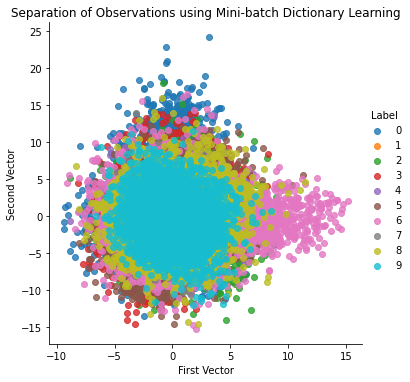

In [81]:
from sklearn.decomposition import MiniBatchDictionaryLearning
n_components = 50
alpha = 1
batch_size = 200
n_iter = 25
random_state = 2018
miniBatchDictLearning = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size, n_iter=n_iter, \
random_state=random_state)
miniBatchDictLearning.fit(X_train.loc[:,:10000])
X_train_miniBatchDictLearning = miniBatchDictLearning.fit_transform(X_train)
X_train_miniBatchDictLearning = pd.DataFrame(data=X_train_miniBatchDictLearning, index=train_index)
X_validation_miniBatchDictLearning = miniBatchDictLearning.transform(X_validation)
X_validation_miniBatchDictLearning = pd.DataFrame(data=X_validation_miniBatchDictLearning,index=validation_index)
scatterPlot(X_train_miniBatchDictLearning, y_train,"Mini-batch Dictionary Learning")

### Independant Component Analysis

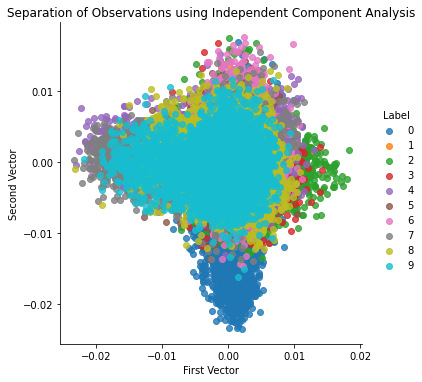

In [82]:
from sklearn.decomposition import FastICA
n_components = 25
algorithm = 'parallel'
whiten = True
max_iter = 100
random_state = 2018
fastICA = FastICA(n_components=n_components, algorithm=algorithm, whiten=whiten, max_iter=max_iter, random_state=random_state)
X_train_fastICA = fastICA.fit_transform(X_train)
X_train_fastICA = pd.DataFrame(data=X_train_fastICA, index=train_index)
X_validation_fastICA = fastICA.transform(X_validation)
X_validation_fastICA = pd.DataFrame(data=X_validation_fastICA, index=validation_index)
scatterPlot(X_train_fastICA, y_train, "Independent Component Analysis")